# Capstone: Trump vs Stock Market

# Exploratory Data Anlysis Notebook

## Contents
- [Problem statement](#Problem-statement)
- [Data dictionary](#Data-dictionary)
- [Loading Data Sets](#Loading-Data-Sets)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature engineering on Holdout](#Feature-engineering-on-Holdout)
- [Train and Validate data](#Train-and-Validate-data)


## Problem statement: 

The US market team at a local bank has seen literature on models that are able to predict market movement based on tweets by Donald Trump:
- [JP Morgan creating a 'Volfefe index to track tweets vs bond interest rates](https://www.marketwatch.com/story/are-trump-tweets-influencing-bond-volatility-jp-morgans-volfefe-index-aims-to-find-out-2019-09-09)
- [On days when President Trump tweets a lot, the stock market falls, Bank of America](https://www.cnbc.com/2019/09/03/on-days-when-president-trump-tweets-a-lot-the-stock-market-falls-investment-bank-finds.html)

They have tasked the data science team to build a classification model using Natural Language Processing to predict if Donald Trump's tweets are market moving. The models used are:
- Logistic Regression
- XGBoost
- Long Short Term Memory Neural Network
- Evaluate the models based on:
    - accuracy (% predictions the model gets correct, both a significant movement and a non-significant movement)
    - precision (% predicted significant movement when it is actually significant movement)
    - sensitivity (% predicted significant movement out of all correct predictions)
- choose the best performing model to test it on the holdout csv

In [1]:
# importing libraries
import numpy as np
import random
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Importing visualisation libraries
from progressbar import ProgressBar
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# NLP libraries
import nltk
import spacy
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Data dictionary

### df_tweets
| Feature     	| Type 	| Description|                                                  
|:------------------	|:----------	|:----------------------------------------------------------------------------------|
| content	| object | Raw tweets from therealdonaldtrump |
| date	| object | Date of his tweet. YYYY-MM-DD-HH-MM-SS format |
| retweets	| int64 | Number of retweets by others at the time of data collection |
| favorites	| int64 | Number of favourites at the time of data collection |
| cleaned_tweets | object | Pre-processed tweets |
| tweet_day	| datetime64[ns] | Date of tweet YYYY-MM-DD format |
| month_sin	| float64 | Cycial sin month feature engineered. Range of -1 to 1 |
| month_cos	| float64 | Cycical cosine month feature engineered. Range of -1 to 1 |
| day_sin	| float64 | Cycical sin day feature engineered. Range of -1 to 1 |
| day_cos	| float64 | Cycical cosine day feature engineered. Range of -1 to 1 |
| hour_sin	| float64 | Cycical sin hour feature engineered. Range of -1 to 1 |
| hour_cos	| float64 | Cycical cosine hour feature engineered. Range of -1 to 1 |
| min_sin	| float64 | Cycical sin min feature engineered. Range of -1 to 1 |
| min_cos	| float64 | Cycical cosine min feature engineered. Range of -1 to 1 |
| time_to_open	| float64 | Time before the stock market opens on that day. In seconds | 	
| time_after_close	| float64 | Time after the stock market closes on that day. In seconds |	
| potus_status	| int64 | President of the United States status |
| vader_negative	| float64 | Negative sentiment analysis using Vader. Scale of 0 to 1 |
| vader_neutral	| float64 | Neutral sentiment analysis using Vader. Scale of 0 to 1 |
| vader_positive	| float64 | Positive sentiment analysis using Vader. Scale of 0 to 1 |
| vader_compound	| float64 | Overall sentiment analysis using Vader. Scale of 0 to 1 |	
| negative_word	| int64 | Negative word count using Loughran McDonald Financial sentiment analysis |
| positive_word	| int64 | Positive word count using Loughran McDonald Financial sentiment analysis |
| uncertainty_word	| int64 | Uncertainty word count using Loughran McDonald Financial sentiment analysis |
| litigious_word	| int64 | Litigious word count using Loughran McDonald Financial sentiment analysis |
| constraining_word	| int64 | Constraining word count using Loughran McDonald Financial sentiment analysis |
| interesting_word	| int64 | Interesting word count using Loughran McDonald Financial sentiment analysis |
| modal_strong_word	| int64 | Modal Strong word count using Loughran McDonald Financial sentiment analysis |
| modal_neutral_word	| int64 | Modal Neutral word count using Loughran McDonald Financial sentiment analysis |
| modal_weak_word	| int64 | Modal Weak word count using Loughran McDonald Financial sentiment analysis |
| difference	| float64 | Intra-day difference between opening and closing S&P500 stock price  	
| target	| int64 | Target variable |

### df_stock_price
S&P500 index


| Feature     	| Type 	| Description|                                                  
|:------------------	|:----------	|:----------------------------------------------------------------------------------|
| Date	| object | Date of S&P500 |
| Open	| float64 | Opening price |
| High	| float64 | Highest price |
| Low	| float64 | Lowest price |
| Close	| float64 | Closing price |
| Volume	| int64 | Volume of stocks traded |
| Dividends	| int64 | Dividends paid out |
| Stock Splits	| int64 | Number of splits |
| difference	| float64 | Difference between opening and closing in % |

# Loading Data Sets

In [2]:
df_train_validate = pd.read_csv('./datasets/df_train_validate.csv',index_col=0)

In [3]:
X_holdout = pd.read_csv('./datasets/X_holdout.csv',index_col=0)

In [4]:
df_stock_price = pd.read_csv('./datasets/df_stock_price.csv')

In [5]:
df_train_validate.head()

,content,date,retweets,favorites,cleaned_tweets,tweet_day,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,min_sin,min_cos,time_to_open,time_after_close,potus_status,vader_negative,vader_neutral,vader_positive,vader_compound,negative_word,positive_word,uncertainty_word,litigious_word,constraining_word,interesting_word,modal_strong_word,modal_neutral_word,modal_weak_word,difference,target
24974,""" @ LeghanLiptak712: CNN tried to destroy Dona...",2015-09-20 04:27:54,1123,2400,leghanliptak cnn tried to destroy donald trump...,2015-09-20,-1.000000,-1.836970e-16,-0.790776,-0.612106,0.866025,5.000000e-01,0.309017,-0.951057,18126.0,0.0,0,0.078,0.658,0.264,0.8113,2,0,0,0,0,0,0,0,0,NaN,0
17951,""" @ InsideCableNews @ FTVLive Dream on. You ha...",2014-10-20 18:59:09,17,38,insidecablenews ftvlive dream on you have a be...,2014-10-20,-0.866025,5.000000e-01,-0.790776,-0.612106,-1.000000,-1.836970e-16,-0.104528,0.994522,0.0,10749.0,0,0.152,0.638,0.210,0.2263,1,2,0,0,0,0,0,0,0,0.009753,1
1138,"""The American work ethic is what led generatio...",2012-01-13 13:48:23,93,40,the american work ethic is what led generation...,2012-01-13,0.500000,8.660254e-01,0.485302,-0.874347,-0.258819,-9.659258e-01,-0.951057,0.309017,0.0,0.0,0,0.000,0.755,0.245,0.6369,0,1,0,0,0,0,0,0,0,-0.004425,0
17957,"Wow, one of the all-time greats in fashion, OS...",2014-10-21 04:20:56,157,192,wow one of the all time great in fashion oscar...,2014-10-21,-0.866025,5.000000e-01,-0.897805,-0.440394,0.866025,5.000000e-01,0.866025,-0.500000,18544.0,0.0,0,0.068,0.653,0.279,0.7953,0,3,0,0,0,1,0,0,0,0.016707,1
32423,Received a # HurricaneHarvey briefing this mor...,2017-08-25 11:02:33,6920,34234,received a hurricaneharvey briefing this morni...,2017-08-25,-0.866025,-5.000000e-01,-0.937752,0.347305,0.258819,-9.659258e-01,0.207912,0.978148,0.0,0.0,1,0.000,1.000,0.000,0.0000,0,0,0,0,0,0,0,0,0,-0.000683,0


In [6]:
# loding NLTK stopwords
stopwords_nltk = set(stopwords.words('english'))

# loading in spacy stopwords
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

for i in stopwords_nltk:
    all_stopwords.add(i)

additional_stop_words = ['twitter', 'pic', 'https', 'com', 'http', 'www', 'bit', 'ly', 'realdonaldtrump']    

for i in additional_stop_words:
    all_stopwords.add(i)

# Exploratory Data Analysis

### Frequency of tweets

C:\Users\russ\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  


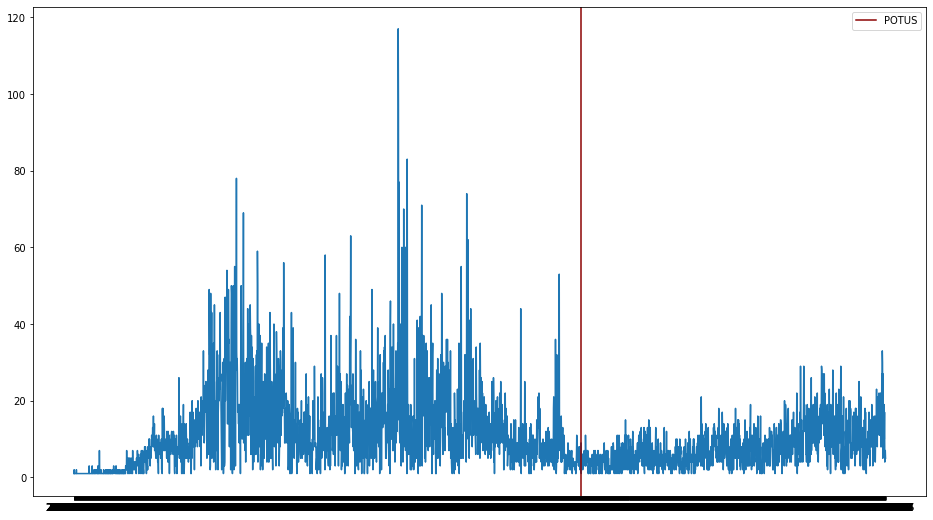

In [7]:
potus_day = pd.to_datetime('2017-01-20')

plt.figure(figsize=(16,9))
plt.plot(df_train_validate.groupby('tweet_day').size())
plt.axvline(x='2017-01-20',ymin=0,ymax=160,color='darkred', label='POTUS')
plt.locator_params(axis='x',tight=True,nbins=10)
plt.legend();

In [8]:
#Total tweets
print('Total number of tweets:',df_train_validate.groupby('tweet_day').size().sum())

#Tweets as a potus
print('Total number of tweets as POTUS:',df_train_validate[df_train_validate['potus_status']==1].groupby('tweet_day').size().sum())

#number of days as potus
print('Number of days as POTUS:',(pd.to_datetime('2020-06-17') - potus_day))

# Avg. tweets as potus 
print('Average number of tweets per day as POTUS',df_train_validate[df_train_validate['potus_status']==1].groupby('tweet_day').size().mean())

#number of days as not as potus since start of data
print('Number of days as not as POTUS since start of dataset:',(potus_day - pd.to_datetime('2009-05-04')))

# Avg number of tweets before pouts
print('Average number of tweets not as POTUS',df_train_validate[df_train_validate['potus_status']==0].groupby('tweet_day').size().mean())


Total number of tweets: 34595
Total number of tweets as POTUS: 9644
Number of days as POTUS: 1244 days 00:00:00
Average number of tweets per day as POTUS 7.911402789171452
Number of days as not as POTUS since start of dataset: 2818 days 00:00:00
Average number of tweets not as POTUS 12.303254437869823


In [9]:
# Avg. tweets as potus
print('Average number of tweets per active tweet day as POTUS in postive class',df_train_validate[(df_train_validate['potus_status']==1) & (df_train_validate['target']==1)].groupby('tweet_day').size().mean())

print('Average number of tweets per active tweet day as POTUS in negative class',df_train_validate[(df_train_validate['potus_status']==1) & (df_train_validate['target']==0)].groupby('tweet_day').size().mean())


Average number of tweets per active tweet day as POTUS in postive class 9.007407407407408
Average number of tweets per active tweet day as POTUS in negative class 7.7749077490774905


### Visualising the positive vs negative class

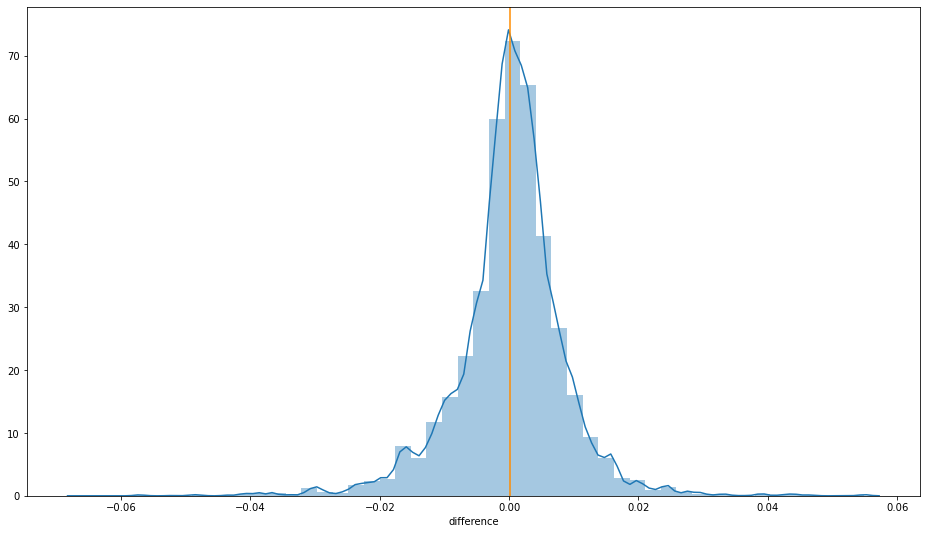

In [10]:
plt.figure(figsize=(16,9))
sns.distplot(df_train_validate['difference']).axvline(df_train_validate['difference'].mean(), color='darkorange')

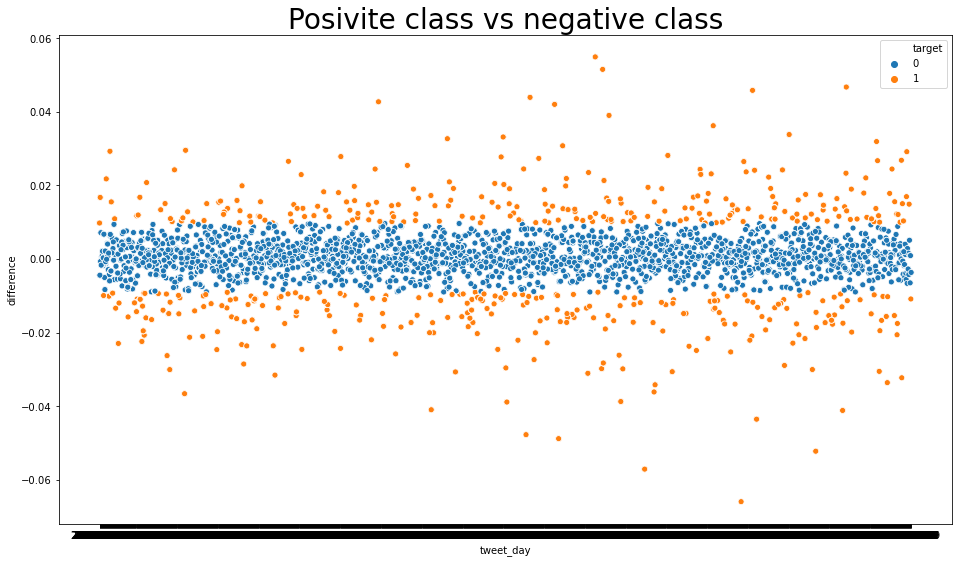

In [11]:
plt.figure(figsize=(16,9))
sns.scatterplot(x=df_train_validate['tweet_day'], 
                y=df_train_validate['difference'],
                hue=df_train_validate['target'])
plt.title('Posivite class vs negative class', fontsize= 28);

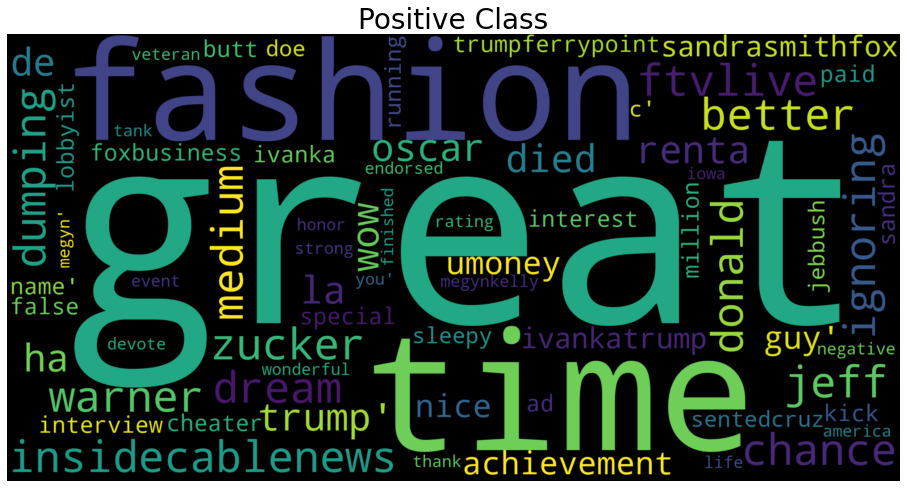

In [12]:
# Wordcloud of positive class
wordcloud = WordCloud(stopwords=all_stopwords,
                      width = 2000,
                      height=1000,
                      background_color="black").generate(str(df_train_validate[df_train_validate['target']==1]['cleaned_tweets'].values))

plt.figure(figsize=(16,9))
plt.title('Positive Class', fontsize= 28)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

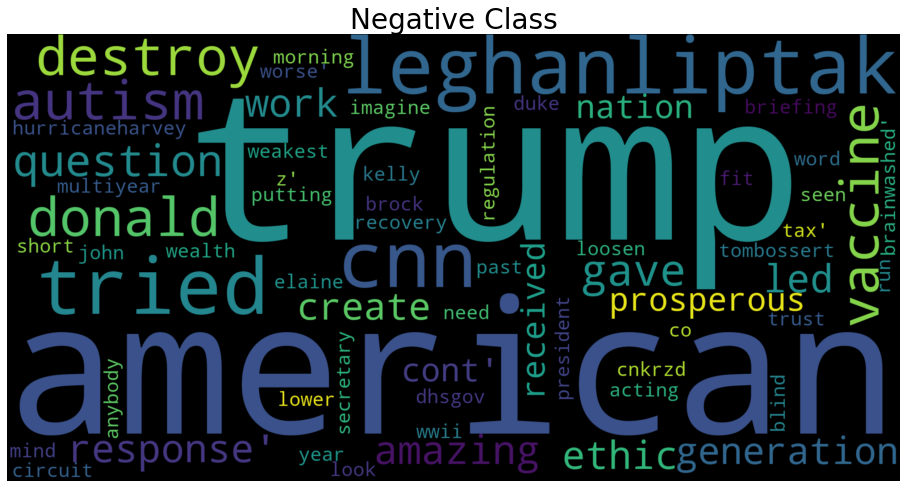

In [13]:
# Wordcloud of negative class
wordcloud = WordCloud(stopwords=all_stopwords,
                      width = 2000,
                      height=1000,
                      background_color="black").generate(str(df_train_validate[df_train_validate['target']==0]['cleaned_tweets'].values))

plt.figure(figsize=(16,9))
plt.title('Negative Class', fontsize= 28)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

### POTUS vs NON-POTUS

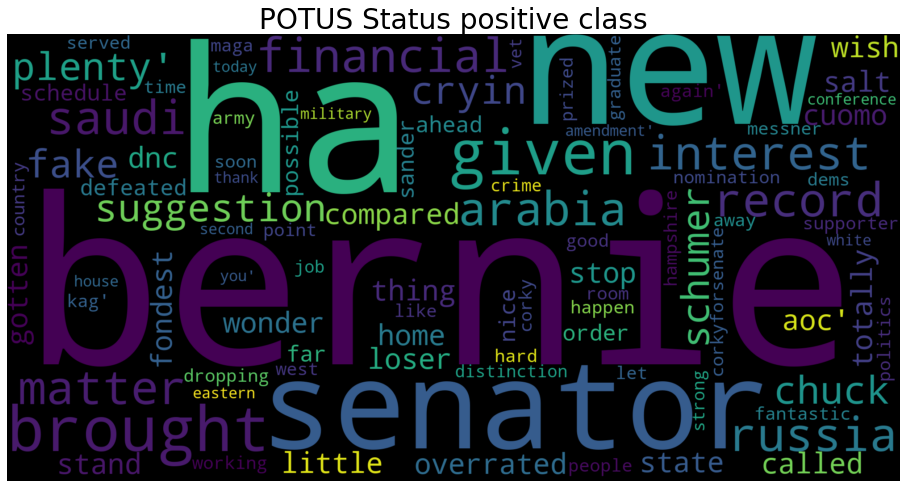

In [14]:
# Wordcloud of POTUS
wordcloud = WordCloud(stopwords=all_stopwords,
                      width = 2000,
                      height=1000,
                      background_color="black").generate(str(df_train_validate[(df_train_validate['potus_status']==1) & (df_train_validate['target']==1)]['cleaned_tweets'].values))

plt.figure(figsize=(16,9))
plt.title('POTUS Status positive class', fontsize= 28)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

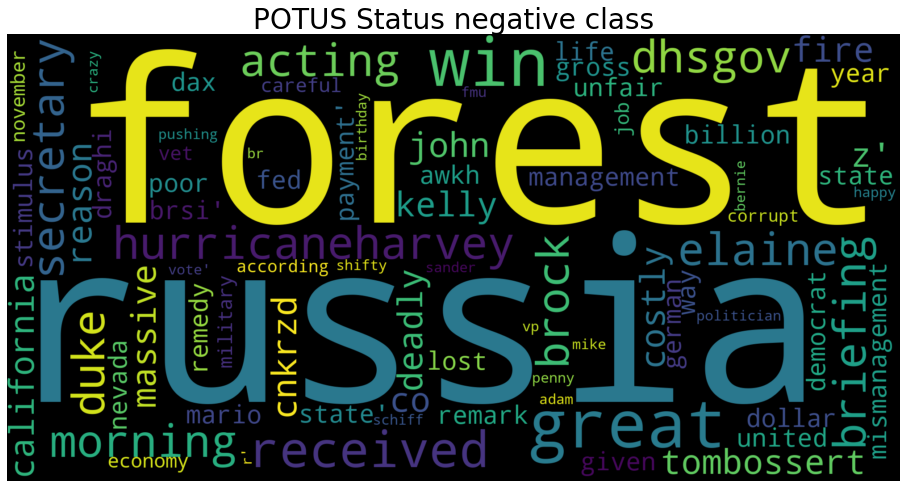

In [15]:
# Wordcloud of POTUS
wordcloud = WordCloud(stopwords=all_stopwords,
                      width = 2000,
                      height=1000,
                      background_color="black").generate(str(df_train_validate[(df_train_validate['potus_status']==1) & (df_train_validate['target']==0)]['cleaned_tweets'].values))

plt.figure(figsize=(16,9))
plt.title('POTUS Status negative class', fontsize= 28)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

### Distribution of number of words

In [16]:
# Creating a new column to count the len of string
df_train_validate['string_count'] = df_train_validate['cleaned_tweets'].map(lambda row: len(str(row)))

# Creating a new column to count the number of words
df_train_validate['word_count'] = df_train_validate['cleaned_tweets'].map(lambda row: len(str(row).split()))

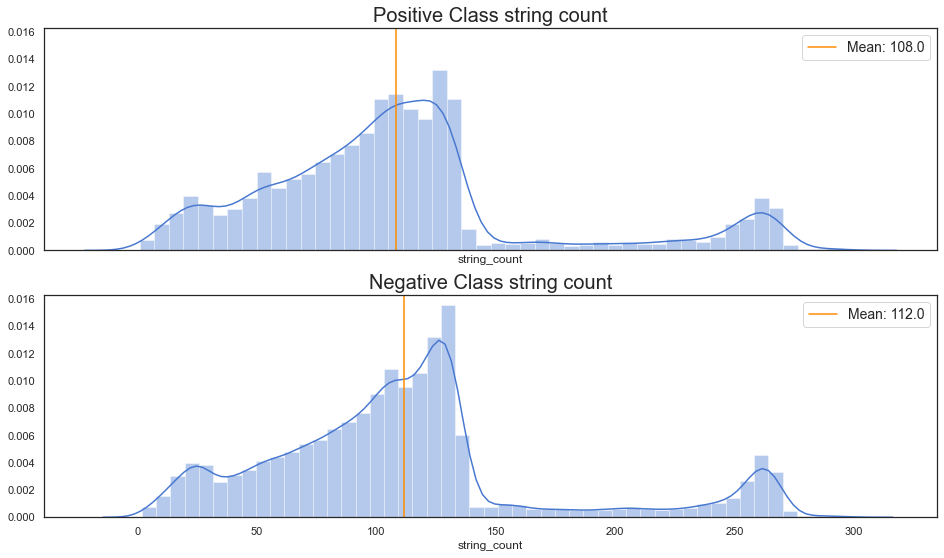

In [17]:
# Distribution of strings
positive_class_count = df_train_validate[df_train_validate['target']==1]['string_count']
negative_class_count = df_train_validate[df_train_validate['target']==0]['string_count']

sns.set(style="white", palette="muted", color_codes=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9), sharex=True, sharey=True)

# Positive Class distplot
sns.distplot(positive_class_count, ax=ax1).axvline(positive_class_count.mean(), color='darkorange')
ax1.set_title('Positive Class string count', fontsize=20)
ax1.legend({f'Mean: {round(positive_class_count.mean(),0)}':positive_class_count.mean()}, fontsize=14)

# AskHistorians distplot
sns.distplot(negative_class_count, ax=ax2).axvline(negative_class_count.mean(), color='darkorange')
ax2.set_title('Negative Class string count', fontsize=20)
ax2.legend({f'Mean: {round(negative_class_count.mean(),0)}':negative_class_count.mean()}, fontsize=14);

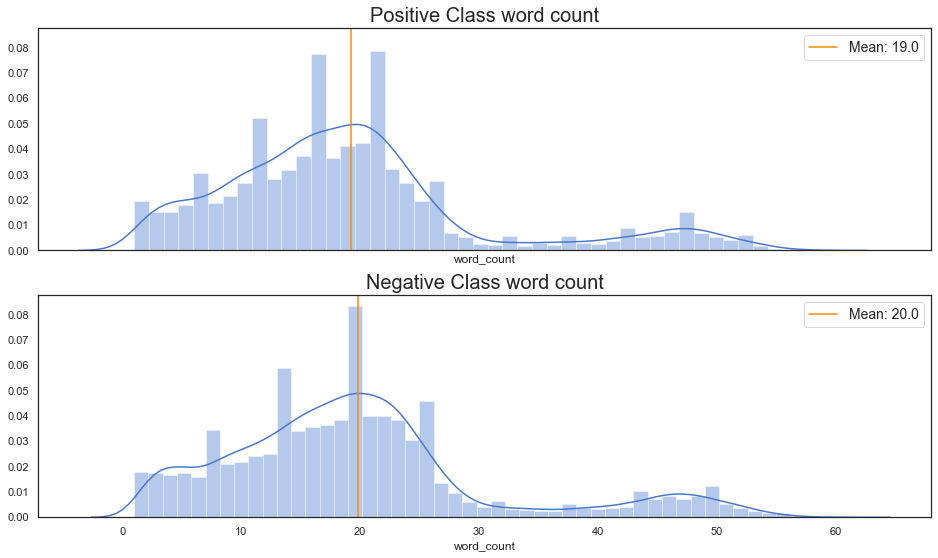

In [18]:
# Distribution of word count
positive_class_word_count = df_train_validate[df_train_validate['target']==1]['word_count']
negative_class_word_count = df_train_validate[df_train_validate['target']==0]['word_count']

sns.set(style="white", palette="muted", color_codes=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9), sharex=True, sharey=True)

# Positive Class distplot
sns.distplot(positive_class_word_count, ax=ax1).axvline(positive_class_word_count.mean(), color='darkorange')
ax1.set_title('Positive Class word count', fontsize=20)
ax1.legend({f'Mean: {round(positive_class_word_count.mean(),0)}':positive_class_word_count.mean()}, fontsize=14)

# AskHistorians distplot
sns.distplot(negative_class_word_count, ax=ax2).axvline(negative_class_word_count.mean(), color='darkorange')
ax2.set_title('Negative Class word count', fontsize=20)
ax2.legend({f'Mean: {round(negative_class_word_count.mean(),0)}':negative_class_word_count.mean()}, fontsize=14);

### Number of unique words used

In [19]:
# Adding number of unique words column
df_train_validate['unique_words_count'] = df_train_validate['cleaned_tweets'].map(lambda x: len(list(str(x).split())))

# as well as the type of unique words
df_train_validate['unique_words'] = df_train_validate['cleaned_tweets'].map(lambda x: list(str(x).split()))

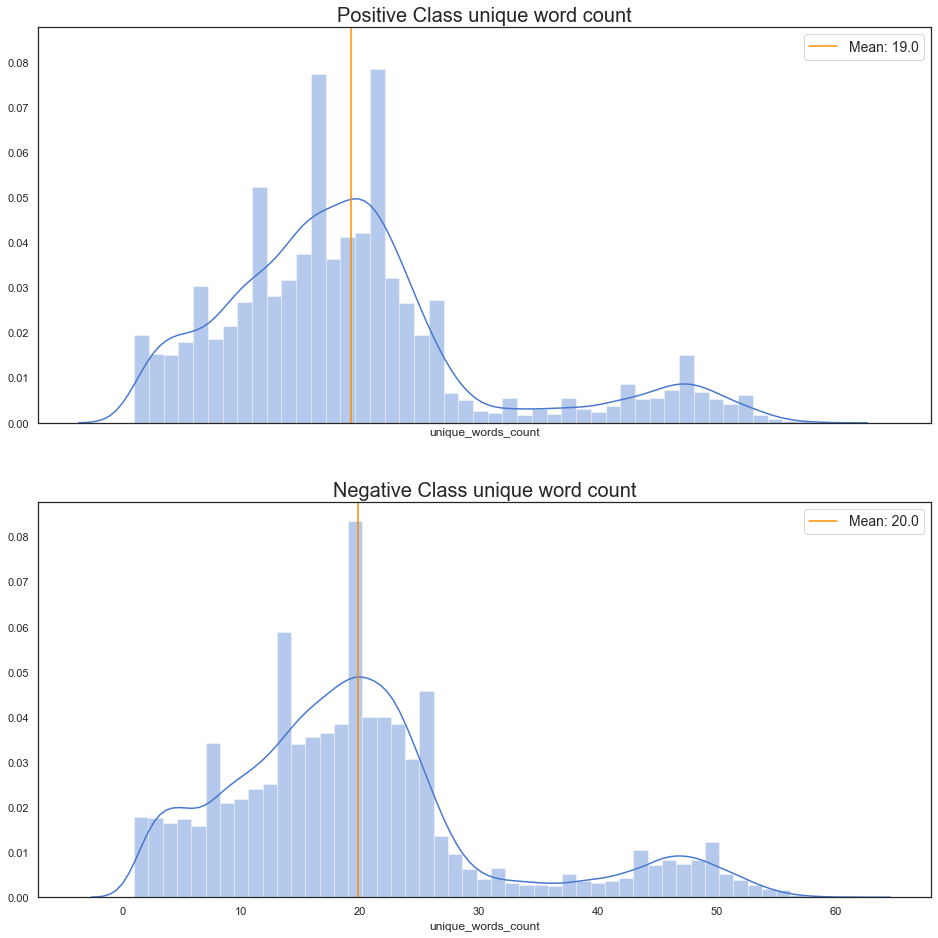

In [20]:
# Distribution of unique words
positive_class_unique_word = df_train_validate[df_train_validate['target']==1]['unique_words_count']
negative_class_unique_word = df_train_validate[df_train_validate['target']==0]['unique_words_count']

sns.set(style="white", palette="muted", color_codes=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,16), sharex=True, sharey=True)

# Positive Class distplot
sns.distplot(positive_class_unique_word, ax=ax1).axvline(positive_class_unique_word.mean(), color='darkorange')
ax1.set_title('Positive Class unique word count', fontsize=20)
ax1.legend({f'Mean: {round(positive_class_unique_word.mean(),0)}':positive_class_unique_word.mean()}, fontsize=14)

# AskHistorians distplot
sns.distplot(negative_class_unique_word, ax=ax2).axvline(negative_class_unique_word.mean(), color='darkorange')
ax2.set_title('Negative Class unique word count', fontsize=20)
ax2.legend({f'Mean: {round(negative_class_unique_word.mean(),0)}':negative_class_unique_word.mean()}, fontsize=14);

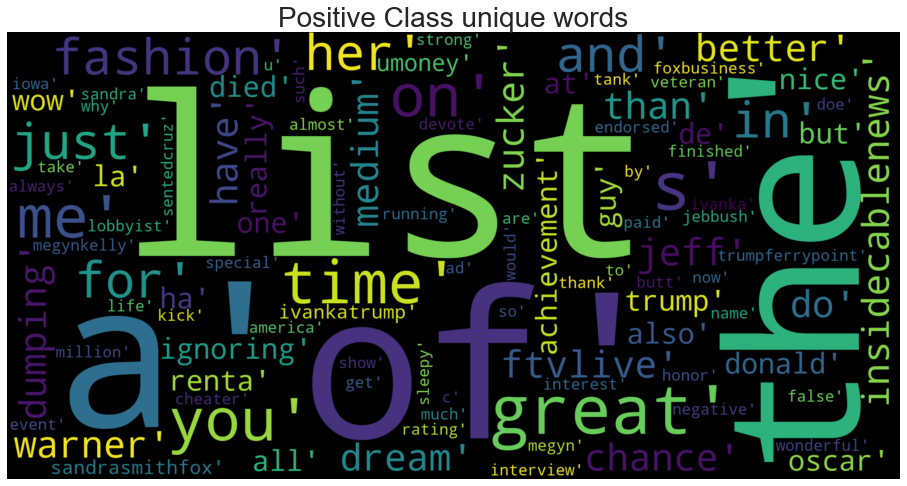

In [21]:
# Wordcloud of unique words positive class
wordcloud = WordCloud(stopwords=all_stopwords,
                      width = 2000,
                      height=1000,
                      background_color="black").generate(str(df_train_validate[df_train_validate['target']==1]['unique_words'].values))

plt.figure(figsize=(16,9))
plt.title('Positive Class unique words', fontsize= 28)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

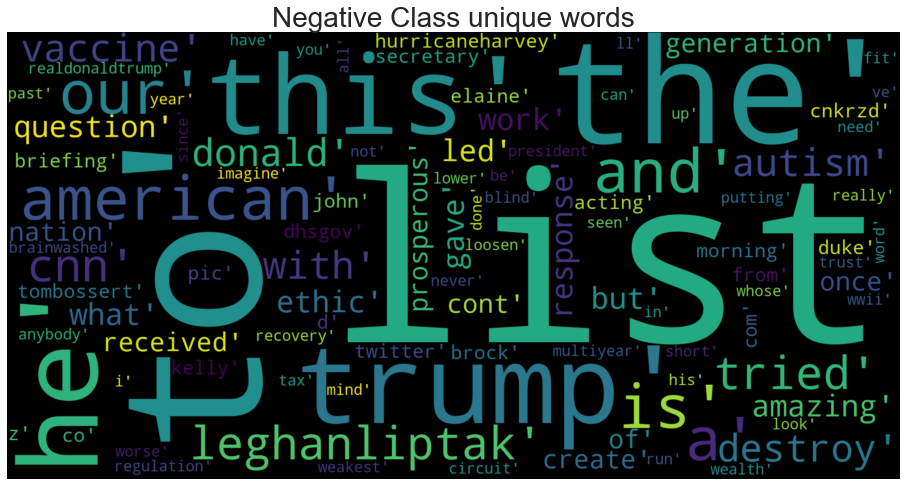

In [22]:
# Wordcloud of unique words negative class
wordcloud = WordCloud(stopwords=all_stopwords,
                      width = 2000,
                      height=1000,
                      background_color="black").generate(str(df_train_validate[df_train_validate['target']==0]['unique_words'].values))

plt.figure(figsize=(16,9))
plt.title('Negative Class unique words', fontsize= 28)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

### Top used words overall

In [23]:
def barplot_cvec(target, title, titles, color, xlimit):
    words_series = df_train_validate[df_train_validate['target']==target]['cleaned_tweets']
    fig,ax = plt.subplots(1,2,figsize=(25,12))
    plt.title(title, fontsize=20)
    ngram=[(1,1),(2,2)]
    for i in range(2):
        
        cvec = CountVectorizer(stop_words = all_stopwords, ngram_range=ngram[i], max_df=(0.9), min_df=(2), max_features=(20))
        
        # tokens into a dataframe
        cvec_df = pd.DataFrame(cvec.fit_transform(words_series).todense(), columns=cvec.get_feature_names())
        sum_words = cvec_df.sum(axis=0)
        top_words = sum_words.sort_values(ascending=False).head(20)
        top_words.sort_values(ascending=True).plot(kind='barh', color=color, ax=ax[i])

        #Plot
        ax[i].set_title(titles[i], size=35, weight='bold')
        ax[i].set_xlabel('Count', size=20)
        ax[i].set_xlim(xlimit)
        ax[i].tick_params(axis='both', which='major', labelsize=20)
        ax[i].tick_params(axis='both', which='minor', labelsize=20)

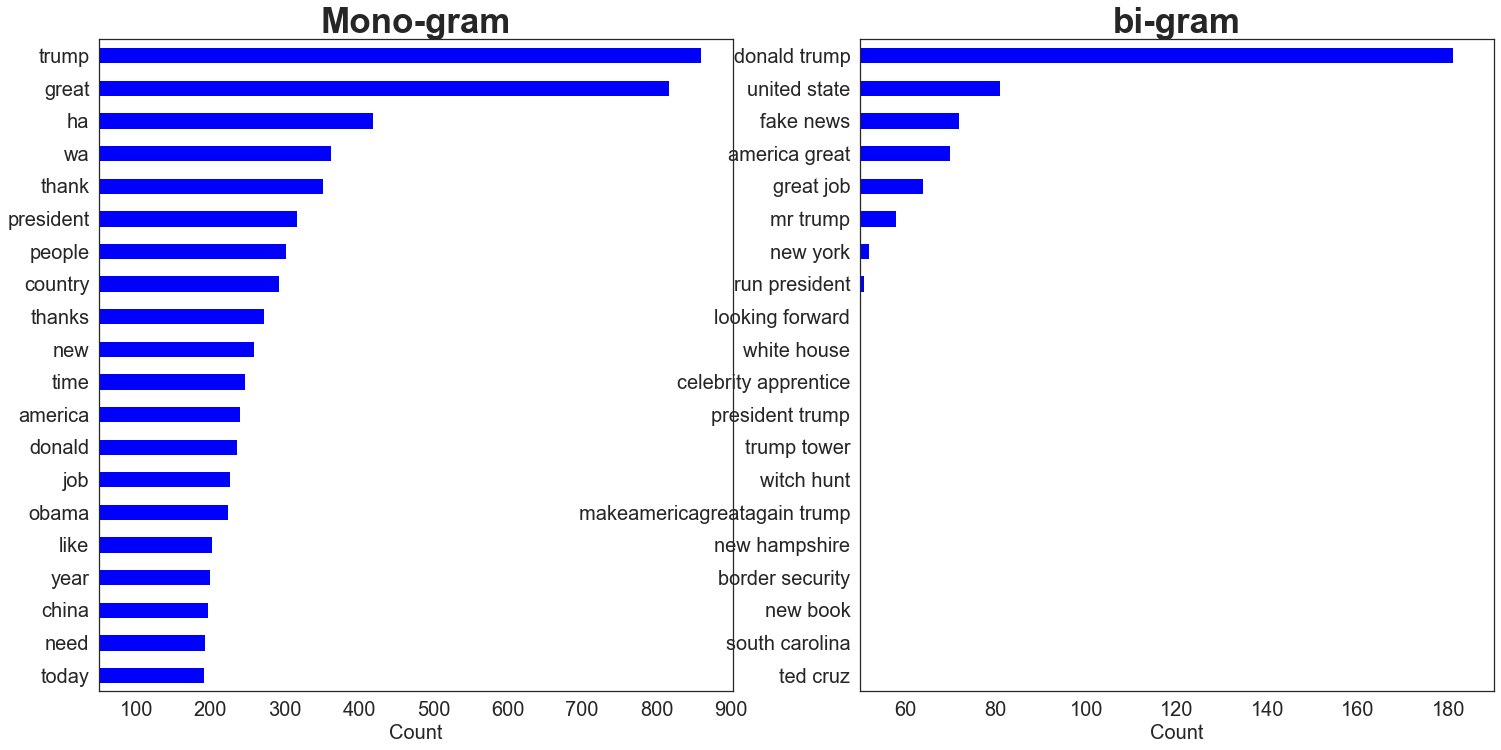

In [24]:
#positive class
barplot_cvec(1, 'Positive Class', ['Mono-gram', 'bi-gram'], 'blue', 50)

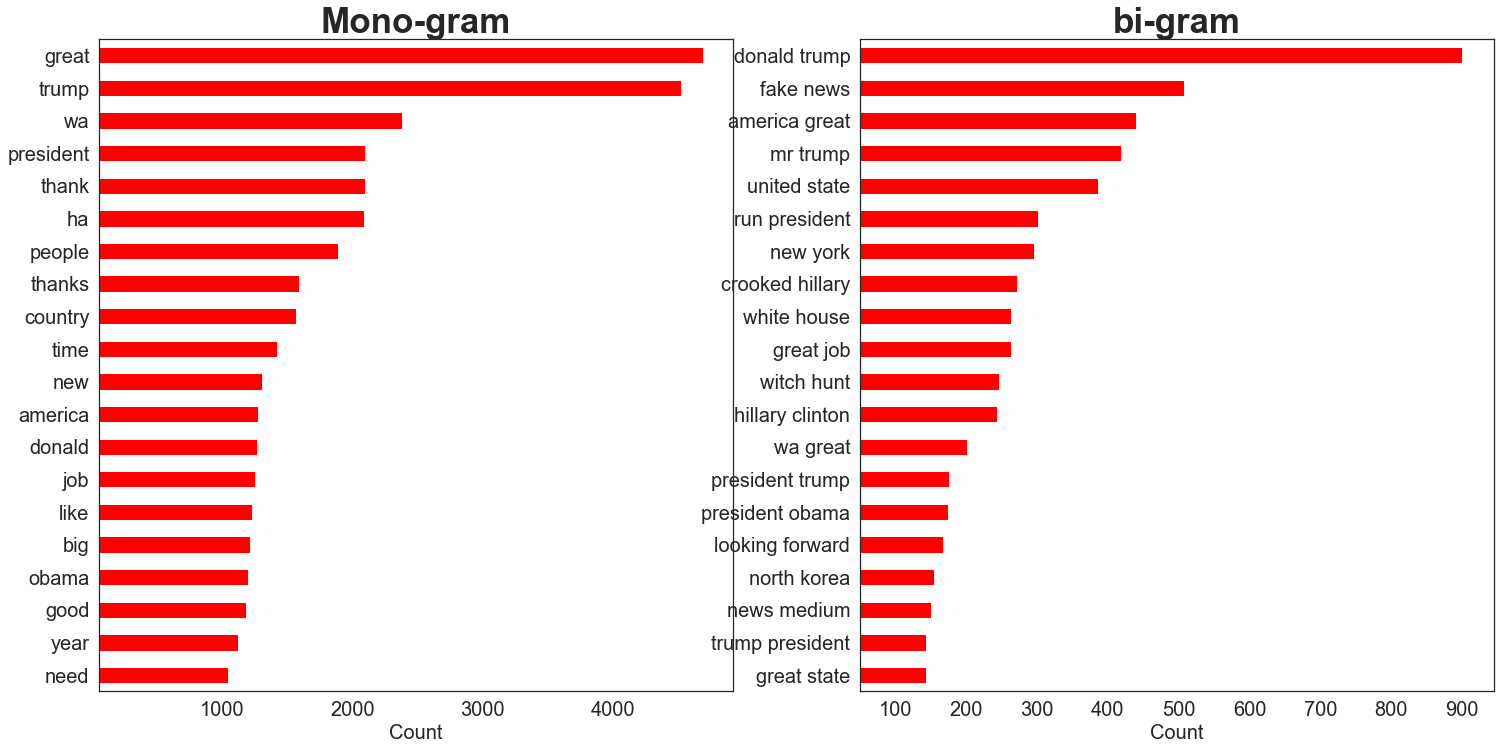

In [25]:
#negative class
barplot_cvec(0, 'Negative class', ['Mono-gram', 'bi-gram'], 'red', 50)

### Top used words during POTUS

In [26]:
def barplot_cvec_potus(target, titles, color, xlimit, potus):
    words_series = df_train_validate[(df_train_validate['target']==target) & (df_train_validate['potus_status']==potus)]['cleaned_tweets']
    fig,ax = plt.subplots(1,2,figsize=(25,12))
    ngram=[(1,1),(2,2)]
    for i in range(2):
        
        cvec = CountVectorizer(stop_words = all_stopwords, ngram_range=ngram[i], max_df=(0.9), min_df=(2), max_features=(20))
        
        # tokens into a dataframe
        cvec_df = pd.DataFrame(cvec.fit_transform(words_series).todense(), columns=cvec.get_feature_names())
        sum_words = cvec_df.sum(axis=0)
        top_words = sum_words.sort_values(ascending=False).head(20)
        top_words.sort_values(ascending=True).plot(kind='barh', color=color, ax=ax[i])

        #Plot
        ax[i].set_title(titles[i], size=35, weight='bold')
        ax[i].set_xlabel('Count', size=20)
        ax[i].set_xlim(xlimit)
        ax[i].tick_params(axis='both', which='major', labelsize=20)
        ax[i].tick_params(axis='both', which='minor', labelsize=20)

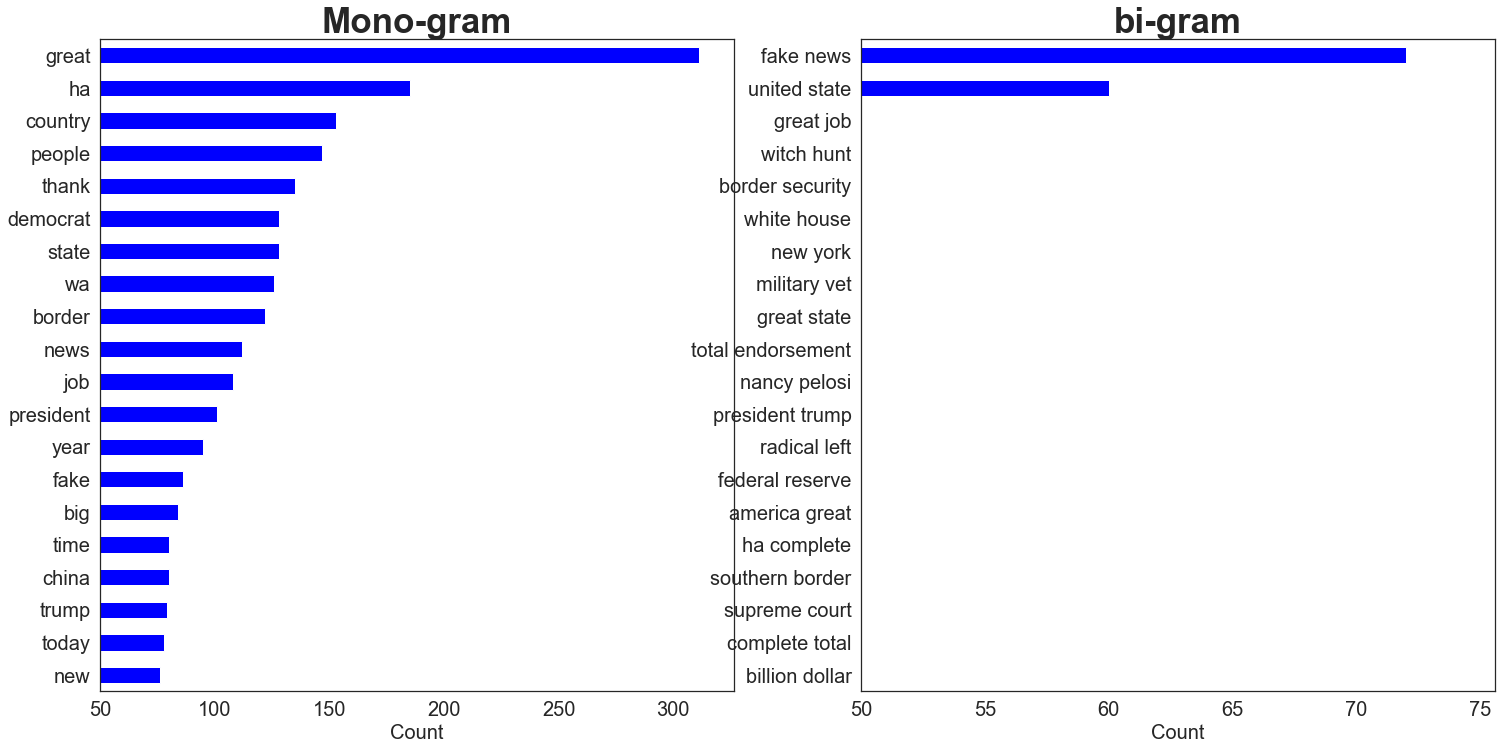

In [27]:
barplot_cvec_potus(1, ['Mono-gram', 'bi-gram'], 'blue', 50, 1)

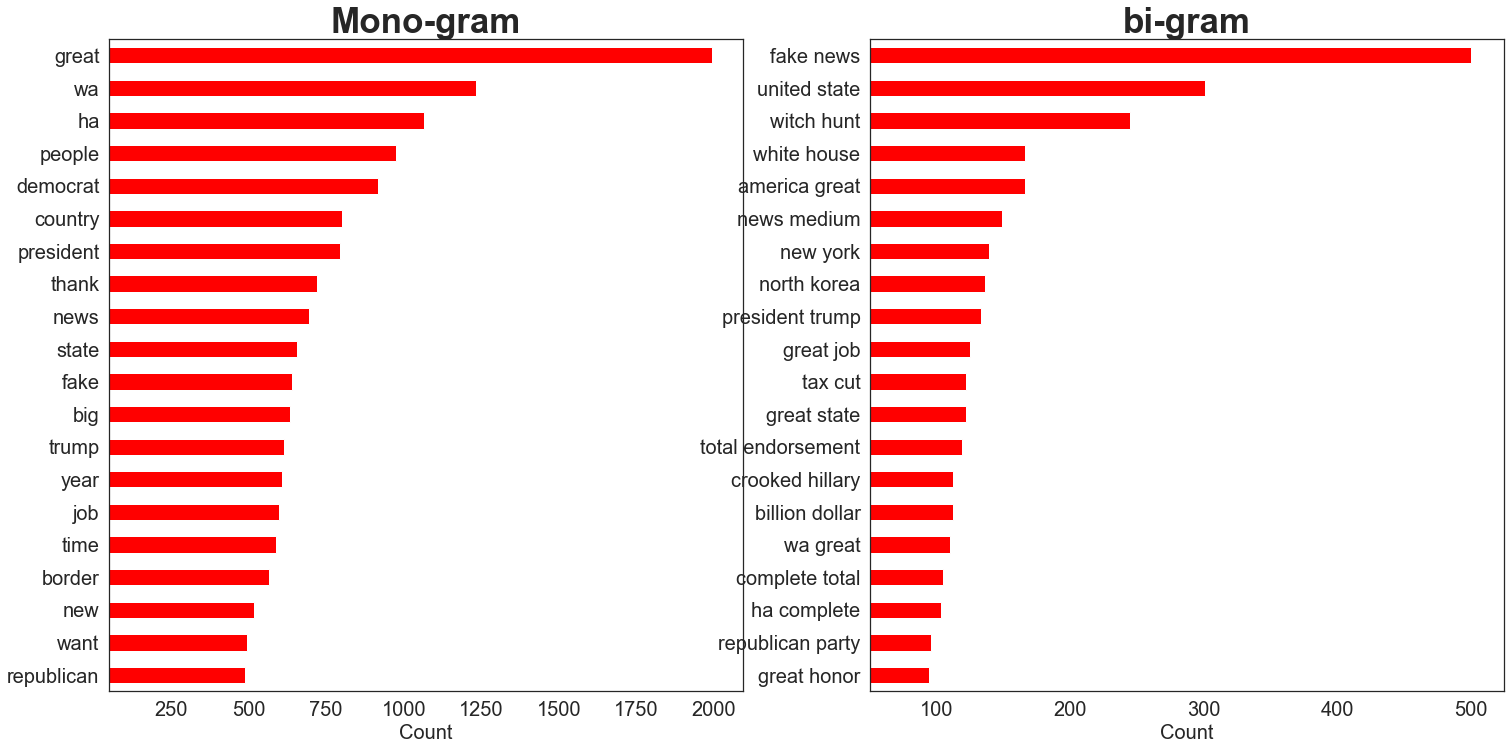

In [28]:
barplot_cvec_potus(0, ['Mono-gram', 'bi-gram'], 'red', 50, 1)

## Correlation

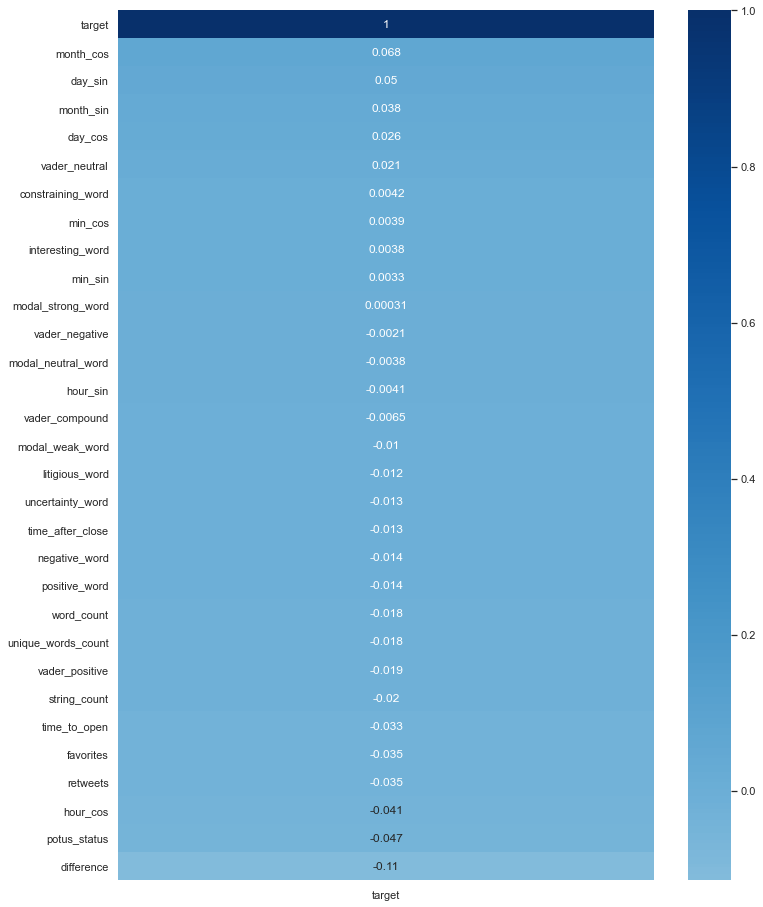

In [29]:
figure = plt.figure(figsize=(12,16))
sns.heatmap(df_train_validate.corr()[['target']].sort_values('target',ascending=False),annot=True, cmap='Blues', center=0)

# Topic Modeling

In [30]:
df_train_validate.head()

,content,date,retweets,favorites,cleaned_tweets,tweet_day,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,min_sin,min_cos,time_to_open,time_after_close,potus_status,vader_negative,vader_neutral,vader_positive,vader_compound,negative_word,positive_word,uncertainty_word,litigious_word,constraining_word,interesting_word,modal_strong_word,modal_neutral_word,modal_weak_word,difference,target,string_count,word_count,unique_words_count,unique_words
24974,""" @ LeghanLiptak712: CNN tried to destroy Dona...",2015-09-20 04:27:54,1123,2400,leghanliptak cnn tried to destroy donald trump...,2015-09-20,-1.000000,-1.836970e-16,-0.790776,-0.612106,0.866025,5.000000e-01,0.309017,-0.951057,18126.0,0.0,0,0.078,0.658,0.264,0.8113,2,0,0,0,0,0,0,0,0,NaN,0,109,17,17,"[leghanliptak, cnn, tried, to, destroy, donald..."
17951,""" @ InsideCableNews @ FTVLive Dream on. You ha...",2014-10-20 18:59:09,17,38,insidecablenews ftvlive dream on you have a be...,2014-10-20,-0.866025,5.000000e-01,-0.790776,-0.612106,-1.000000,-1.836970e-16,-0.104528,0.994522,0.0,10749.0,0,0.152,0.638,0.210,0.2263,1,2,0,0,0,0,0,0,0,0.009753,1,137,23,23,"[insidecablenews, ftvlive, dream, on, you, hav..."
1138,"""The American work ethic is what led generatio...",2012-01-13 13:48:23,93,40,the american work ethic is what led generation...,2012-01-13,0.500000,8.660254e-01,0.485302,-0.874347,-0.258819,-9.659258e-01,-0.951057,0.309017,0.0,0.0,0,0.000,0.755,0.245,0.6369,0,1,0,0,0,0,0,0,0,-0.004425,0,100,17,17,"[the, american, work, ethic, is, what, led, ge..."
17957,"Wow, one of the all-time greats in fashion, OS...",2014-10-21 04:20:56,157,192,wow one of the all time great in fashion oscar...,2014-10-21,-0.866025,5.000000e-01,-0.897805,-0.440394,0.866025,5.000000e-01,0.866025,-0.500000,18544.0,0.0,0,0.068,0.653,0.279,0.7953,0,3,0,0,0,1,0,0,0,0.016707,1,127,26,26,"[wow, one, of, the, all, time, great, in, fash..."
32423,Received a # HurricaneHarvey briefing this mor...,2017-08-25 11:02:33,6920,34234,received a hurricaneharvey briefing this morni...,2017-08-25,-0.866025,-5.000000e-01,-0.937752,0.347305,0.258819,-9.659258e-01,0.207912,0.978148,0.0,0.0,1,0.000,1.000,0.000,0.0000,0,0,0,0,0,0,0,0,0,-0.000683,0,151,24,24,"[received, a, hurricaneharvey, briefing, this,..."


In [31]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\russ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
positive_class = [list(TextBlob(x.lower()).words) for x in df_train_validate[df_train_validate['target']==1]['cleaned_tweets'].values[0:25]]
negative_class = [list(TextBlob(x.lower()).words) for x in df_train_validate[df_train_validate['target']==0]['cleaned_tweets'].values[0:25]]

In [33]:
positive = [[w for w in doc if w not in all_stopwords] for doc in positive_class]
negative = [[w for w in doc if w not in all_stopwords] for doc in negative_class]

In [34]:
#K topics
K=5

In [35]:
# get the documents and all the words:
D = positive
W = [w for wordlist in D for w in wordlist]
print(len(D), len(W))

25 271


In [36]:
# get the UNIQUE words:
W_unique = list(np.unique(W))
print(len(W_unique))

228


In [37]:
# Make the topics. Each topic will have a dictionary of counts of occurrances
# of each word, which we will set to zero for now:
Z = {i:{w:0 for w in W_unique} for i in range(K)}

In [38]:
# go through all the words in all the documents, and randomly assign each
# one to one of the topics:
D_z = [[[w, np.random.choice(range(K))] for w in d] for d in D]

In [39]:
Z.keys()

dict_keys([0, 1, 2, 3, 4])

In [40]:
# update the topic dictionaries:
for d in D_z:
    for w, z in d:  
        Z[z][w] += 1

In [41]:
Z[0]

{'accomplished': 1,
 'achievement': 0,
 'act': 1,
 'agree': 0,
 'ahead': 0,
 'america': 0,
 'aoc': 0,
 'arabia': 0,
 'art': 0,
 'astonishing': 1,
 'autism': 0,
 'away': 0,
 'believe': 0,
 'belong': 0,
 'bernie': 0,
 'best': 0,
 'better': 1,
 'betterhermann': 1,
 'bid': 0,
 'biden': 0,
 'big': 0,
 'black': 0,
 'borrowing': 0,
 'brought': 1,
 'buffalo': 0,
 'buffalobills': 0,
 'business': 0,
 'butt': 1,
 'calebccooper': 0,
 'called': 0,
 'carry': 1,
 'cause': 0,
 'celebrityapprentice': 0,
 'chance': 0,
 'chicago': 0,
 'child': 0,
 'china': 0,
 'chuck': 0,
 'city': 0,
 'class': 1,
 'club': 1,
 'compared': 0,
 'conquered': 0,
 'cont': 0,
 'continue': 0,
 'cool': 0,
 'crazy': 0,
 'created': 0,
 'criminal': 0,
 'cryin': 1,
 'cuomo': 1,
 'de': 0,
 'deal': 1,
 'defeated': 0,
 'deficit': 0,
 'democrat': 0,
 'died': 0,
 'dnc': 0,
 'donald': 0,
 'donaldtrump': 0,
 'dream': 0,
 'dropping': 0,
 'dumping': 0,
 'election': 0,
 'entrepreneurship': 0,
 'excuse': 1,
 'fake': 1,
 'far': 0,
 'fashion': 1,

In [42]:
# p(z|d): proportion of words in document d assigned to topic z
def topic_given_doc(z_ind, d):
    return np.sum([w_z[1] == z_ind for w_z in d])/float(len(d))

In [43]:
# p(w|z): proportion of words in topic z that are this word
def word_given_topic(w, z):
    total_words = np.sum(list(z.values()))
    if total_words == 0:
        return 0.
    else:
        return z[w]/float(total_words)

In [44]:
def sample_topic(Z, document, word):
    probs = []
    for i in range(len(Z)):
        probs.append(topic_given_doc(i, document) * word_given_topic(word, Z[i]))
    if np.sum(probs) == 0:
        return -1
    return np.random.choice(range(len(Z)), p=np.array(probs)/np.sum(probs))

In [45]:
# WARNING: SLOW!
def topic_iterator(Z, D_z, iters=20):
    for it in range(iters):
        print('iter:', it)
        for d_ind in range(len(D_z)):
            for w_ind in range(len(D_z[d_ind])):
                old_topic = D_z[d_ind][w_ind][1]
                word = D_z[d_ind][w_ind][0]
                new_topic = sample_topic(Z, D_z[d_ind], word)
                if new_topic != -1:
                    Z[old_topic][word] = max(0, Z[old_topic][word]-1)
                    Z[new_topic][word] = Z[new_topic][word]+1

In [46]:
# WARNING: SLOW!
topic_iterator(Z, D_z)

iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19


In [47]:
def topic_dist(document, K=5):
    for z in range(K):
        print('topic:', z, 'P:', topic_given_doc(z, document))

In [48]:
for d, doc in enumerate(D_z[0:3]):
    print('document:', d)
    topic_dist(doc)
    print('-'*40)

document: 0
topic: 0 P: 0.2857142857142857
topic: 1 P: 0.2857142857142857
topic: 2 P: 0.14285714285714285
topic: 3 P: 0.2857142857142857
topic: 4 P: 0.0
----------------------------------------
document: 1
topic: 0 P: 0.13333333333333333
topic: 1 P: 0.3333333333333333
topic: 2 P: 0.13333333333333333
topic: 3 P: 0.3333333333333333
topic: 4 P: 0.06666666666666667
----------------------------------------
document: 2
topic: 0 P: 0.18181818181818182
topic: 1 P: 0.2727272727272727
topic: 2 P: 0.09090909090909091
topic: 3 P: 0.18181818181818182
topic: 4 P: 0.2727272727272727
----------------------------------------


In [49]:
def topic_top_words(z, top=5):
    word_sum = np.sum(list(z.values()))
    word_counts = sorted(z.items(), key=lambda x: x[1], reverse=True)
    top_words = [[w, c/float(word_sum)] for w, c in word_counts[0:top]]
    for w, p in top_words:
        print(w, p)

In [50]:
for z_ind in range(K):
    print('topic:', z_ind)
    topic_top_words(Z[z_ind])
    print('-'*40)

topic: 0
guy 0.36585365853658536
ignoring 0.12804878048780488
fashion 0.12195121951219512
time 0.12195121951219512
accomplished 0.006097560975609756
----------------------------------------
topic: 1
thing 0.23668639053254437
time 0.13609467455621302
better 0.1242603550295858
poor 0.1242603550295858
medium 0.09467455621301775
----------------------------------------
topic: 2
ha 0.2457627118644068
nice 0.17372881355932204
bernie 0.08898305084745763
brought 0.08898305084745763
number 0.08898305084745763
----------------------------------------
topic: 3
trump 0.26521739130434785
people 0.1782608695652174
donald 0.09130434782608696
ivanka 0.09130434782608696
business 0.08695652173913043
----------------------------------------
topic: 4
great 0.33793103448275863
child 0.14482758620689656
truly 0.14482758620689656
use 0.14482758620689656
agree 0.006896551724137931
----------------------------------------


# Feature engineering on Holdout

In [51]:
# Creating a new column to count the len of string
X_holdout['string_count'] = X_holdout['cleaned_tweets'].map(lambda row: len(str(row)))

# Creating a new column to count the number of words
X_holdout['word_count'] = X_holdout['cleaned_tweets'].map(lambda row: len(str(row).split()))

# Adding number of unique words column
X_holdout['unique_words_count'] = X_holdout['cleaned_tweets'].map(lambda x: len(list(str(x).split())))

# as well as the type of unique words
X_holdout['unique_words'] = X_holdout['cleaned_tweets'].map(lambda x: list(str(x).split()))

# Creating a new column to count the len of string
X_holdout['string_count'] = X_holdout['cleaned_tweets'].map(lambda row: len(str(row)))

# Creating a new column to count the number of words
X_holdout['word_count'] = X_holdout['cleaned_tweets'].map(lambda row: len(str(row).split()))

In [52]:
X_holdout.to_csv('./datasets/X_holdout.csv')

# Train and Validate data

In [53]:
df_train_validate.columns

Index(['content', 'date', 'retweets', 'favorites', 'cleaned_tweets',
       'tweet_day', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin',
       'hour_cos', 'min_sin', 'min_cos', 'time_to_open', 'time_after_close',
       'potus_status', 'vader_negative', 'vader_neutral', 'vader_positive',
       'vader_compound', 'negative_word', 'positive_word', 'uncertainty_word',
       'litigious_word', 'constraining_word', 'interesting_word',
       'modal_strong_word', 'modal_neutral_word', 'modal_weak_word',
       'difference', 'target', 'string_count', 'word_count',
       'unique_words_count', 'unique_words'],
      dtype='object')

In [54]:
X = df_train_validate.drop(['target'], axis=1)
y = df_train_validate['target']

In [55]:
# Train and validate data split
X_train, X_validate, y_train, y_validate = train_test_split(X,
                                                            y,
                                                            stratify=y, 
                                                            random_state=42, 
                                                            test_size=0.2)

In [56]:
X_holdout.head()

,content,date,retweets,favorites,cleaned_tweets,tweet_day,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,min_sin,min_cos,time_to_open,time_after_close,potus_status,vader_negative,vader_neutral,vader_positive,vader_compound,negative_word,positive_word,uncertainty_word,litigious_word,constraining_word,interesting_word,modal_strong_word,modal_neutral_word,modal_weak_word,difference,string_count,word_count,unique_words_count,unique_words
29145,I have raised/given a tremendous amount of mon...,2016-05-31 06:42:20,4550,16531,i have raised given a tremendous amount of mon...,2016-05-31,5.000000e-01,-0.866025,-2.449294e-16,1.000000,1.000000,6.123234e-17,-9.510565e-01,-0.309017,10060.0,0.0,0,0.000,0.760,0.240,0.7661,1,2,0,0,0,0,0,0,0,-0.001514,127,24,24,"[i, have, raised, given, a, tremendous, amount..."
16282,Via @ dallasnews’ @ neighborsgo by Heather Noe...,2014-07-07 14:12:26,18,32,via dallasnews neighborsgo by heather noel she...,2014-07-07,-5.000000e-01,-0.866025,9.884683e-01,0.151428,-0.500000,-8.660254e-01,9.510565e-01,0.309017,0.0,0.0,0,0.000,1.000,0.000,0.0000,0,0,0,0,0,0,0,0,0,-0.003311,110,15,15,"[via, dallasnews, neighborsgo, by, heather, no..."
33332,"The Democrats have been told, and fully unders...",2017-12-29 07:16:11,29123,127446,the democrat have been told and fully understa...,2017-12-29,-2.449294e-16,1.000000,-3.943559e-01,0.918958,0.965926,-2.588190e-01,9.945219e-01,-0.104528,8029.0,0.0,1,0.156,0.755,0.088,-0.5730,0,0,0,0,0,0,1,1,0,-0.005779,261,45,45,"[the, democrat, have, been, told, and, fully, ..."
6590,Great to see @ Yankees Captain Derek Jeter bac...,2013-02-19 11:49:58,143,59,great to see yankee captain derek jeter back o...,2013-02-19,8.660254e-01,0.500000,-6.513725e-01,-0.758758,0.258819,-9.659258e-01,-9.135455e-01,0.406737,0.0,0.0,0,0.000,0.639,0.361,0.9062,0,2,0,0,0,0,1,0,0,0.007337,116,22,22,"[great, to, see, yankee, captain, derek, jeter..."
17792,"""@YOD_Bagholders: @ realDonaldTrump Trump 4 Pr...",2014-10-13 06:30:17,37,65,bagholders realdonaldtrump trump president clo...,2014-10-13,-8.660254e-01,0.500000,4.853020e-01,-0.874347,1.000000,6.123234e-17,1.224647e-16,-1.000000,10783.0,0.0,0,0.000,0.790,0.210,0.4912,0,0,0,0,0,0,0,0,0,-0.016220,82,11,11,"[bagholders, realdonaldtrump, trump, president..."


In [57]:
#dropping unncessasry columns
X_train.drop(['difference', 'date', 'tweet_day', 'unique_words','content'],axis=1, inplace=True)
X_validate.drop(['difference', 'date', 'tweet_day', 'unique_words','content'],axis=1, inplace=True)
X_holdout.drop(['difference', 'date', 'tweet_day', 'unique_words','content'],axis=1, inplace=True)

C:\Users\russ\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [58]:
# Saving train, validate and holdout data
y_train.to_csv('./datasets/y_train.csv')
y_validate.to_csv('./datasets/y_validate.csv')

X_train.to_csv('./datasets/X_train.csv')
X_validate.to_csv('./datasets/X_validate.csv')

X_holdout.to_csv('./datasets/X_holdout.csv')